# Add Object Detections

In this recipe, we will be covering how you can add detection model predictions to your dataset. First we will go through how to add predictions using the FiftyOne Model Zoo and apply_model. In the second part, we will demonstrate how to add your detection predictions from your own custom model. Feel free to skip ahead if you are interested in only custom models!

## Setup

If you haven't already, install FiftyOne:

In [ ]:
!pip install fiftyone

Let's kick things off by loading in the [MSCOCO 2017](https://cocodataset.org/#home) validation split from the [FiftyOne Dataset Zoo](https://docs.voxel51.com/user_guide/dataset_zoo/datasets.html#coco-2017). We will cap it to a max of 1000 samples:

Found annotations at '/home/dan/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use



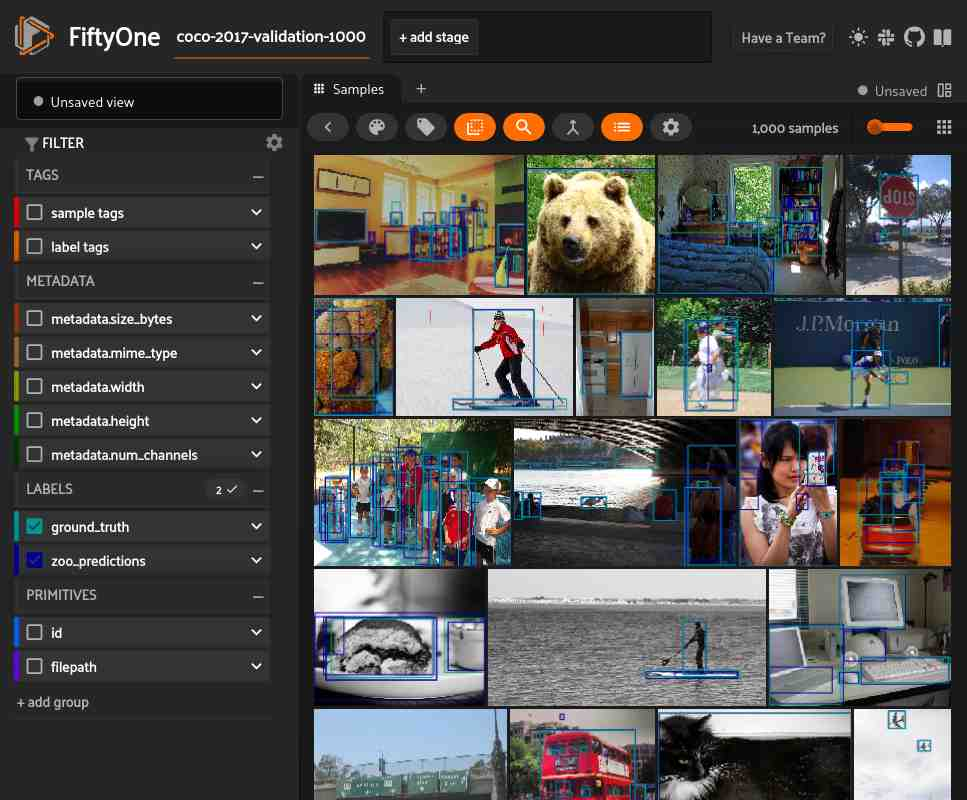

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("coco-2017", split="validation", max_samples=1000)

session = fo.launch_app(dataset)

## Adding Predictions With Model Zoo

With FiftyOne, you have tons of pretrained models at your disposal to use via the [FiftyOne Model Zoo](https://docs.voxel51.com/user_guide/model_zoo/index.html) or using one of our [integrations](https://docs.voxel51.com/integrations/index.html) such as [HuggingFace](https://docs.voxel51.com/integrations/huggingface.html)! To get started using them, first load the model in and pass it into the `apply_model` function. We will use [retinanet-resnet50-fpn-coco-torch](https://docs.voxel51.com/user_guide/model_zoo/models.html#retinanet-resnet50-fpn-coco-torch) from the model zoo first!

In [2]:
model = foz.load_zoo_model("retinanet-resnet50-fpn-coco-torch")
dataset.apply_model(model, label_field="zoo_predictions")

 100% |███████████████| 1000/1000 [54.8s elapsed, 0s remaining, 18.6 samples/s]      


Let's visualize our results!

In [ ]:
session.show()

![zoo_det](../assets/zoo_det.png)

## Adding Predictions using Ultralytics

Thanks to [FiftyOne's integration](https://docs.voxel51.com/integrations/ultralytics.html) with [Ultralytics](https://github.com/ultralytics/ultralytics), we can pass any Ultralytics YOLO model into `apply_model` as well!

In [4]:
from ultralytics import YOLO

# YOLOv8
model = YOLO("yolov8s.pt")

# model = YOLO("yolov8m.pt")
# model = YOLO("yolov8l.pt")
# model = YOLO("yolov8x.pt")

# YOLOv5
# model = YOLO("yolov5s.pt")
# model = YOLO("yolov5m.pt")
# model = YOLO("yolov5l.pt")
# model = YOLO("yolov5x.pt")

# YOLOv9
# model = YOLO("yolov9c.pt")
# model = YOLO("yolov9e.pt")
dataset.apply_model(model, label_field="YOLOv8")

100%|██████████| 21.5M/21.5M [00:00<00:00, 23.5MB/s]

   0% ||--------------|    0/1000 [4.0ms elapsed, ? remaining, ? samples/s] 

 100% |███████████████| 1000/1000 [13.4s elapsed, 0s remaining, 75.3 samples/s]      


## Adding Predictions from Custom Model

When bringing your own model to add predictions to your dataset, you can add [detection labels](https://docs.voxel51.com/user_guide/using_datasets.html#object-detection) directly to each sample! The **most** important part to remember is that FiftyOne uses `[nx, ny, nw, nh]` bounding box format, or normalized x,y,w,h notation. This means that each value in the bounding box is between (0,1). Below is a sample function that converts an `xyxy` box to `nxywh`.

In [6]:
def convert_xyxy_boxes(sample, boxes):
    new_boxes = []
    
    for box in boxes:
        
        # Normalize X and Y by width and height
        nx = box[0] / sample.metadata.width
        ny = box[1] / sample.metadata.height
        
        # Calculate width and height and normalize as well
        nw = (box[2] - box[0]) / sample.metadata.width
        nh = (box[3] - box[1]) / sample.metadata.height
        new_box = [nx, ny, nw, nh]
        new_boxes.append(new_box)
        
    return new_boxes

For our custom model in this example, we will be using `torchvision` [FasterRCNN_Resnet50](https://docs.voxel51.com/user_guide/using_datasets.html#object-detection). The pattern for adding custom labels looks like this:

1. Load the sample image
2. Perform any necessary preprocessing
3. Inference on the image
4. Grab the prediction and confidence of the model_output
5. Adjust the bounding box if needed
6. Add the values as a label to your sample

Let's walkthrough them below!

In [11]:
prediction["scores"].tolist()

[0.9968947172164917,
 0.9962496161460876,
 0.9944279193878174,
 0.9800991415977478,
 0.9770545363426208,
 0.9260280132293701,
 0.9172775745391846,
 0.917271077632904,
 0.9105761647224426,
 0.9044170379638672]

In [14]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)

# Compute Metadata to collect each samples width and height
dataset.compute_metadata() 

for sample in dataset:
    
    # Step 1: Load the image
    image = read_image(sample.filepath)

    # Step 2: Preform preprocessing
    preprocess = weights.transforms()


    batch = [preprocess(image)]

    # Step 3: Inference on the image
    model.eval()
    prediction = model(batch)[0]
    
    # Step 4: Grab the prediction and confidence
    labels = [weights.meta["categories"][i] for i in prediction["labels"]]
    confs = prediction["scores"].tolist()
    fo_boxes = convert_xyxy_boxes(sample, prediction["boxes"].tolist())
    detections = []
    
    for cls, box, conf in zip(labels, fo_boxes, confs):
        
        det = fo.Detection(label=cls, bounding_box=box, confidence=conf)
        detections.append(det)
        
    sample["torchvision"] = fo.Detections(detections=detections)
    sample.save()

Finally, we can see all of our results in the FiftyOne App!

In [ ]:
session.show()